In [20]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import h5py


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"GPU Detected: {gpu.device_type} - {gpu.name}")
else:
    print("No GPU detected")

GPU Detected: GPU - /physical_device:GPU:0
GPU Detected: GPU - /physical_device:GPU:1


# All data

In [4]:
# Open the HDF5 file
hdf5_file = 'processed_images_all.hdf5'
with h5py.File(hdf5_file, 'r') as file:
    # Read the test labels dataset into a numpy array
    test_labels = file['test_images_labels'][:]

# Create a DataFrame from the labels
test_labels = pd.DataFrame(test_labels, columns=['label'])

test_labels.shape

(3574, 1)

## Inspect images file content

In [5]:
# Function to inspect the contents of an HDF5 file
def inspect_hdf5_file(filepath):
    # Open the HDF5 file
    with h5py.File(filepath, 'r') as file:
        print("Datasets contained within the file:")
        for dataset_name in file:
            # Access the dataset
            dataset = file[dataset_name]
            # Print details about the dataset
            print(f"Dataset Info: {dataset_name}, {dataset.shape}, {dataset.dtype}")

# Call the function to inspect the HDF5 file
inspect_hdf5_file(hdf5_file)

Datasets contained within the file:
Dataset Info: test_images, (3574, 224, 224, 3), float64
Dataset Info: test_images_labels, (3574,), int32
Dataset Info: train_images, (28561, 224, 224, 3), float64
Dataset Info: train_images_labels, (28561,), int32
Dataset Info: valid_images, (3579, 224, 224, 3), float64
Dataset Info: valid_images_labels, (3579,), int32


## Image generator function

In [6]:
# Define a generator function to load images from the HDF5 file
def hdf5_image_generator(filepath, dataset_name, batch_size):
    while True:  # Loop indefinitely
        with h5py.File(filepath, 'r') as file:
            images = file[dataset_name]
            labels = file[dataset_name + '_labels']  # Adjust if your labels are stored differently
            num_samples = images.shape[0]

            for start in range(0, num_samples, batch_size):
                end = min(start + batch_size, num_samples)
                yield images[start:end], labels[start:end]

batch_size = 32

# Create generators for training and validation
train_generator = hdf5_image_generator(hdf5_file, 'train_images', batch_size)
valid_generator = hdf5_image_generator(hdf5_file, 'valid_images', batch_size)
test_generator = hdf5_image_generator(hdf5_file, 'test_images', batch_size)

# Get the lengths of the datasets
def get_dataset_lengths(filepath):
    with h5py.File(filepath, 'r') as file:
        lengths = {}
        for dataset_name in file:
            dataset = file[dataset_name]
            lengths[dataset_name] = len(dataset)
    return lengths

dataset_lengths = get_dataset_lengths(hdf5_file)
train_steps_per_epoch = dataset_lengths['train_images'] // batch_size
valid_steps = dataset_lengths['valid_images'] // batch_size
test_steps = (dataset_lengths['test_images'] + batch_size - 1) // batch_size

## Early stopping callback

In [5]:
# Implement EarlyStopping callback function
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor the validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,            # Log when training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

## Model

In [19]:
# Load the base model with pre-trained weights on ImageNet and without the top layer
vgg16_base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Flatten the output layer to 1 dimension
x = Flatten()(vgg16_base_model.output)

# Add a fully connected layer with 256 hidden units and ReLU activation
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Add a final softmax layer for classification
output = Dense(10, activation='softmax')(x)

# Configure and compile the model
vgg16_model = Model(inputs=vgg16_base_model.input, outputs=output)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Fit model

In [7]:
# Fit the model using the generator
vgg16_model_history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    callbacks=[early_stopping]
)

Epoch 1/50


2024-05-14 22:37:55.161547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-14 22:37:56.312810: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f306d1ec400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-14 22:37:56.312856: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2024-05-14 22:37:56.312872: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-05-14 22:37:56.322331: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 22:37:56.409812: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


892/892 [==============================] - 239s 261ms/step - loss: 1.6850 - accuracy: 0.3483 - val_loss: 1.6533 - val_accuracy: 0.3730
Epoch 2/50
892/892 [==============================] - 236s 263ms/step - loss: 1.6518 - accuracy: 0.3567 - val_loss: 1.6414 - val_accuracy: 0.3730
Epoch 3/50
892/892 [==============================] - 234s 262ms/step - loss: 1.6587 - accuracy: 0.3605 - val_loss: 1.6415 - val_accuracy: 0.3730
Epoch 4/50
892/892 [==============================] - 234s 263ms/step - loss: 1.6360 - accuracy: 0.3608 - val_loss: 1.6419 - val_accuracy: 0.3730
Epoch 5/50
892/892 [==============================] - 238s 267ms/step - loss: 1.6352 - accuracy: 0.3608 - val_loss: 1.6422 - val_accuracy: 0.3730
Epoch 6/50
892/892 [==============================] - 235s 263ms/step - loss: 1.6342 - accuracy: 0.3608 - val_loss: 1.6418 - val_accuracy: 0.3730
Epoch 7/50
892/892 [==============================] - 233s 262ms/step - loss: 1.6337 - accuracy: 0.3610 - val_loss: 1.6415 - val_accura

### Save model

In [8]:
vgg16_model.save('models/vgg16_model_all.keras')

### Load model

In [9]:
# Load the model from the .h5 file
vgg16_model = load_model('models/vgg16_model_all.keras')

### Evaluate

In [10]:
# Perform evaluation
test_loss, test_acc = vgg16_model.evaluate(test_generator, steps=test_steps)
print("VGG16 Model Test Accuracy:", test_acc)

112/112 [==============================] - 6s 51ms/step - loss: 1.6583 - accuracy: 0.3531
VGG16 Model Test Accuracy: 0.353105753660202


### Plot

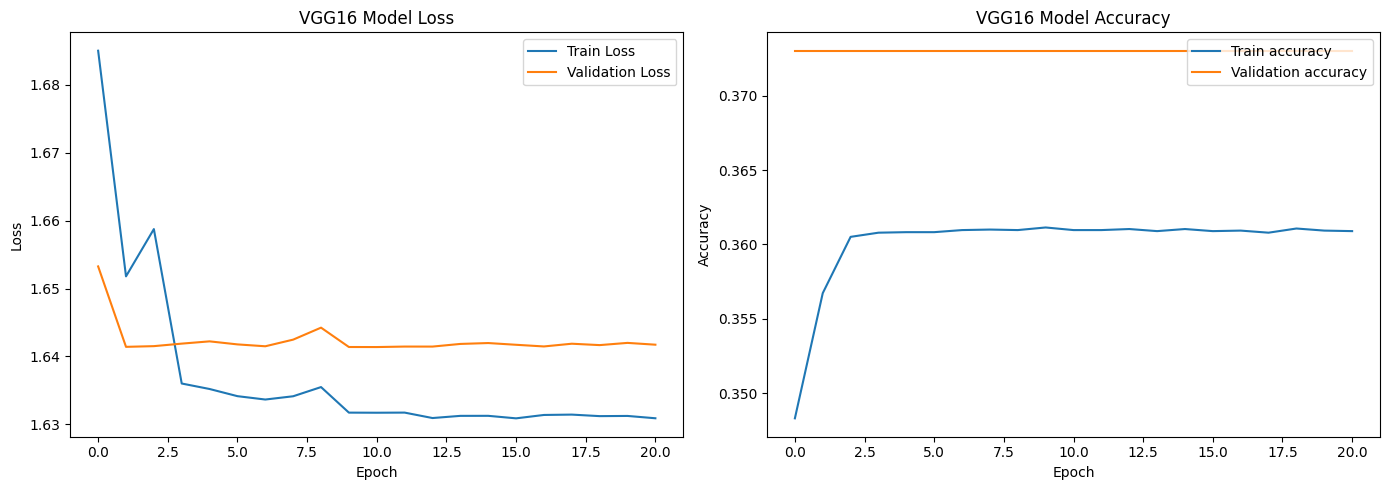

In [11]:
# Plot the history
# Assuming 'history' is the output from your model.fit()
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(vgg16_model_history.history['loss'], label='Train Loss')
plt.plot(vgg16_model_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation mean squared error
plt.subplot(1, 2, 2)
plt.plot(vgg16_model_history.history['accuracy'], label='Train accuracy')
plt.plot(vgg16_model_history.history['val_accuracy'], label='Validation accuracy')
plt.title('VGG16 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [15]:
predictions = vgg16_model.predict(test_generator, steps=test_steps)
predicted_labels = np.argmax(predictions, axis=1)
test_labels, predicted_labels

112/112 [==============================] - 5s 45ms/step


(      label
 0         7
 1         3
 2         0
 3         2
 4         4
 ...     ...
 3569      0
 3570      0
 3571      4
 3572      1
 3573      3
 
 [3574 rows x 1 columns],
 array([0, 0, 0, ..., 0, 0, 0]))

In [18]:
# Get unique values and their counts
unique_values, counts = np.unique(predicted_labels, return_counts=True)

# Print unique values and counts
print("Unique values in predicted labels:", unique_values)
print("Counts of unique values in predicted labels:", counts)

Unique values in predicted labels: [0]
Counts of unique values in predicted labels: [3574]


In [12]:
accuracy = accuracy_score(test_labels, predicted_labels)
print("VGG16 Model Accuracy:", accuracy)

VGG16 Model Accuracy: 0.35310576385002795


### Confusion Matrix

VGG16 Model Confusion Matrix:
 [[1262    0    0    0    0    0    0    0    0    0]
 [ 928    0    0    0    0    0    0    0    0    0]
 [ 444    0    0    0    0    0    0    0    0    0]
 [ 444    0    0    0    0    0    0    0    0    0]
 [ 325    0    0    0    0    0    0    0    0    0]
 [  23    0    0    0    0    0    0    0    0    0]
 [  93    0    0    0    0    0    0    0    0    0]
 [  27    0    0    0    0    0    0    0    0    0]
 [  27    0    0    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0]]


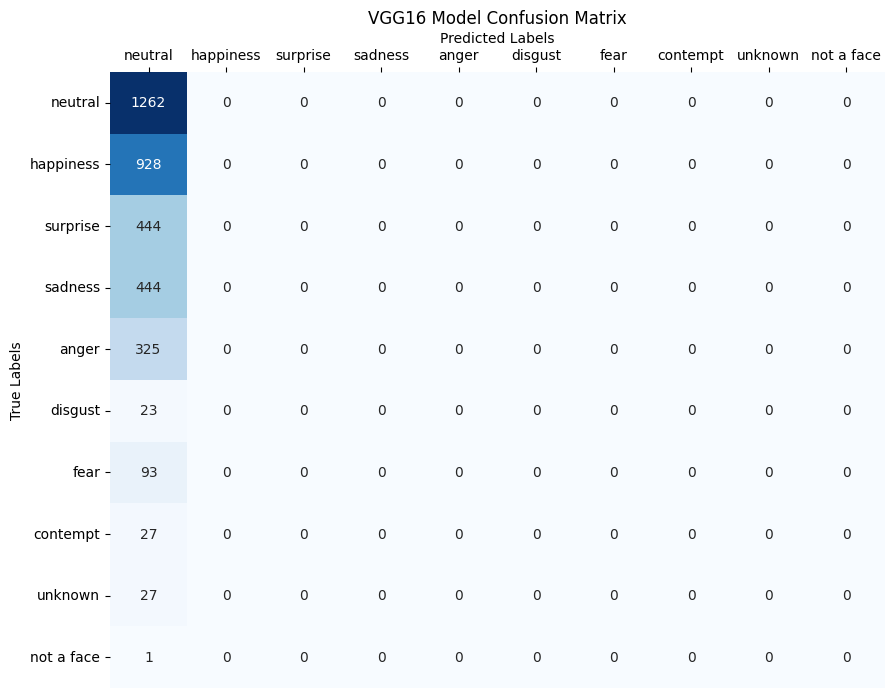

In [14]:
emotion_labels = {
    0: "neutral",
    1: "happiness",
    2: "surprise",
    3: "sadness",
    4: "anger",
    5: "disgust",
    6: "fear",
    7: "contempt",
    8: "unknown",
    9: "not a face"
}

# Get the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("VGG16 Model Confusion Matrix:\n", conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values(), cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('VGG16 Model Confusion Matrix')

# Move the X-axis to the top of the plot
ax.xaxis.tick_top()  # X-axis on top
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top

plt.show()